In [5]:
#Importing the libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
#Reading the traning file
train = pd.read_csv('./data/train_1.csv').fillna(0)
page = train['Page']
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [8]:
#the Page colum is not neccesary for training the model
train=train.drop('Page',axis=1)
train.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [69]:
X = train.iloc[0:1000,0:520]
y = train.iloc[0:1000,521:550]

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc_train_X = MinMaxScaler(feature_range=(0, 1))
sc_train_Y = MinMaxScaler(feature_range=(0, 1))
X_train = sc_train_X.fit_transform(X)
y_train = sc_train_Y.fit_transform(y)

#Reshaping Array
X_train = np.reshape(X_train, (1000,520,1))

# Importing the Keras libraries and packages for LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

# Adding the input layerand the LSTM layer
regressor.add(LSTM(units = 12, activation = 'relu', input_shape = (None, 1)))


# Adding the output layer
regressor.add(Dense(units = 29))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 10, epochs = 3, verbose = 1)

Epoch 1/3
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0010 - acc: 0.0500
Epoch 2/3
1000/1000 [==============================] - 22s 22ms/step - loss: 9.8043e-04 - acc: 0.0500
Epoch 3/3
1000/1000 [==============================] - 22s 22ms/step - loss: 9.3250e-04 - acc: 0.0510


[[17.340847]
 [26.8402  ]
 [21.200455]
 [27.219748]
 [23.731857]
 [23.062744]
 [27.61974 ]
 [23.08617 ]
 [19.80686 ]
 [25.243652]
 [16.15614 ]
 [20.42328 ]
 [23.63421 ]
 [20.408152]
 [22.515362]
 [23.59604 ]
 [22.17999 ]
 [19.971693]
 [23.800955]
 [20.222406]
 [21.139538]
 [22.937885]
 [20.62508 ]
 [18.870436]
 [23.280571]
 [19.99592 ]
 [23.018324]
 [18.51642 ]
 [28.255777]]


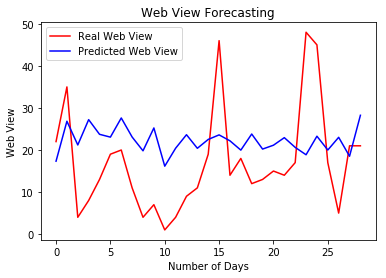

In [82]:
# Getting the predicted Web View
test_row = train.iloc[50000,:].values
X_test = test_row[0:520]
y_test = test_row[521:550]
inputs = X_test
inputs = np.reshape(inputs,(1,-1))
inputs = sc_train_X.transform(inputs)
inputs = np.reshape(inputs, (1, 520, 1))
y_pred = regressor.predict(inputs)
y_pred = sc_train_Y.inverse_transform(y_pred)
y_pred[y_pred < 0] = 0
y_pred = np.reshape(y_pred, (29,1))
print(y_pred)

#Visualising Result
plt.figure
plt.plot(y_test, color = 'red', label = 'Real Web View')
plt.plot(y_pred, color = 'blue', label = 'Predicted Web View')
#plt.plot(X_test, color = 'green', label = 'Previous values')
plt.title('Web View Forecasting')
plt.xlabel('Number of Days')
plt.ylabel('Web View')
plt.legend()
plt.show()

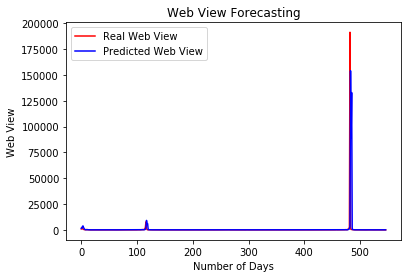

In [29]:
#Training the RNN network on the page 90000
train_row = train.iloc[60282,:].values
X1 = train_row[0:547]
X2 = train_row[1:548]
X3 = train_row[2:549]
y1 = train_row[3:550]
#y2 = train_row[4:549]
#y3 = train_row[5:550]

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = np.reshape(X1,(-1,1))
X_train = np.append(X_train, np.reshape(X2,(-1,1)), axis=1)
X_train = np.append(X_train, np.reshape(X3,(-1,1)), axis=1)
y_train = np.reshape(y1,(-1,1))
#y_train = np.append(y_train, np.reshape(y2,(-1,1)), axis=1)
#y_train = np.append(y_train, np.reshape(y3,(-1,1)), axis=1)
X_train = sc.fit_transform(X_train)
y_train = sc.fit_transform(y_train)

#Training LSTM

#Reshaping Array
X_train = np.reshape(X_train, (547,3,1))

# Importing the Keras libraries and packages for LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

# Adding the input layerand the LSTM layer
regressor.add(LSTM(units = 12, activation = 'relu', input_shape = (None, 1)))


# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 10, epochs = 100, verbose = 0)

# Getting the predicted Web View
test_row = train.iloc[10000,:].values
X_test1 = test_row[0:547]
X_test2 = test_row[1:548]
X_test3 = test_row[2:549]
y_test = test_row[3:550]
inputs = X_test1
inputs = np.reshape(inputs,(-1,1))
inputs = np.append(inputs, np.reshape(X_test2,(-1,1)), axis=1)
inputs = np.append(inputs, np.reshape(X_test3,(-1,1)), axis=1)
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (547, 3, 1))
y_pred = regressor.predict(inputs)
y_pred = sc.inverse_transform(y_pred)
y_pred[y_pred < 0] = 0

#Visualising Result
plt.figure
plt.plot(y_test, color = 'red', label = 'Real Web View')
plt.plot(y_pred, color = 'blue', label = 'Predicted Web View')
plt.title('Web View Forecasting')
plt.xlabel('Number of Days')
plt.ylabel('Web View')
plt.legend()
plt.show()

**Conclusion**
The Reccurant Neural Network using the LSTM layer is able to capture the general trend in the web view traffic of any random page.

In [12]:
# Getting the predicted Web View for page 2400
test_row = train.iloc[2400,:].values
X_test = test_row[0:549]
y_test = test_row[1:550]
inputs = X_test
inputs = np.reshape(inputs,(-1,1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (549, 1, 1))
y_pred = regressor.predict(inputs)
y_pred = sc.inverse_transform(y_pred)

#Visualising Result
plt.figure
plt.plot(y_test, color = 'red', label = 'Real Web View')
plt.plot(y_pred, color = 'blue', label = 'Predicted Web View')
plt.title('Web View Forecasting')
plt.xlabel('Number of Days')
plt.ylabel('Web View')
plt.legend()
plt.show()

ValueError: non-broadcastable output operand with shape (549,1) doesn't match the broadcast shape (549,3)

60282


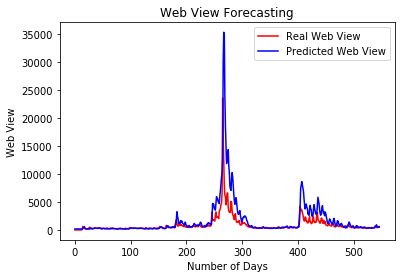

In [32]:
# Getting the Web View for some random page
import random
X_value = random.randint(0,train.shape[0])
print(X_value)
test_row = train.iloc[X_value,:].values
X_test1 = test_row[0:547]
X_test2 = test_row[1:548]
X_test3 = test_row[2:549]
y_test = test_row[3:550]
inputs = X_test1
inputs = np.reshape(inputs,(-1,1))
inputs = np.append(inputs, np.reshape(X_test2,(-1,1)), axis=1)
inputs = np.append(inputs, np.reshape(X_test3,(-1,1)), axis=1)
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (547, 3, 1))
y_pred = regressor.predict(inputs)
y_pred = sc.inverse_transform(y_pred)
y_pred[y_pred < 0] = 0

#Visualising Result
plt.figure
plt.plot(y_test, color = 'red', label = 'Real Web View')
plt.plot(y_pred, color = 'blue', label = 'Predicted Web View')
plt.title('Web View Forecasting')
plt.xlabel('Number of Days')
plt.ylabel('Web View')
plt.legend()
plt.show()


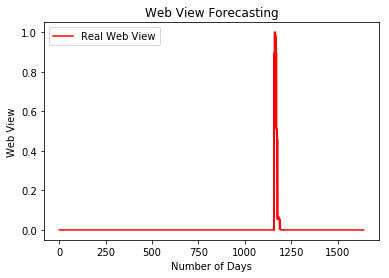

In [20]:
plt.figure
plt.plot(np.reshape(X_train, (-1, 1)), color = 'red', label = 'Real Web View')
plt.title('Web View Forecasting')
plt.xlabel('Number of Days')
plt.ylabel('Web View')
plt.legend()
plt.show()

In [47]:
print(np.reshape(X_train, (-1, 1)))

[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000